In [ ]:
#hide
#all_examples

## Table of Contents
* [Chapter 1](#chapter1)
    * [Section 1.1](#section_1_1)
        * [Sub Section 1.1.1](#sub_section_1_1_1)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
        * [Sub Section 2.1.1](#sub_section_2_1_1)
        * [Sub Section 2.1.2](#sub_section_2_1_2)
    * [Section 2.2](#section_2_2)
        * [Sub Section 2.2.1](#sub_section_2_2_1)
        * [Sub Section 2.2.2](#sub_section_2_2_2)
* [Chapter 3](#chapter3)
    * [Section 3.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2)
    * [Section 3.2](#section_3_2)
        * [Sub Section 3.2.1](#sub_section_3_2_1)
        * [Sub Section 3.2.2](#sub_section_3_2_2)
* [Chapter 4](#chapter4)
* [Chapter 5](#chapter5)
    * [5.1 Predictions](#section_5_1)
* [Chapter 6](#chapter6)
* [Chapter 7](#chapter7)

## 1. Using fastai for semantic segmentation
<a class="anchor" id="chapter1"></a>

Here we use U-net for deadwood semantic segmentation. This notebook is based on the notebook "Using fastai for segmentation" by Janne Mäyrä.

## 1.1 Importing the libraries <a class="anchor" id="section_1_1"></a>

In [1]:
from pathlib import Path
import os
os.environ['PROJ_LIB']='/opt/conda/share/proj' # This should fix "ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed". Does not seem to work as of 17.5.2022. The error message disappears when running this cell a second time though. Using a workaround where using the command "export PROJ_LIB=/opt/conda/share/proj" in the Singularity terminal fixes the issue.
from drone_detector.processing.tiling import * #Commented this one out 18.3.2022 because Janne updated the tiling on 10.3.2022. Look into how to set up the new tiling.

from fastai.vision.all import *
from fastai.callback.wandb import * # Added 24.11.2022
from fastai.callback.progress import ShowGraphCallback # Added 24.11.2022
from drone_detector.engines.fastai.data import *
from drone_detector.metrics import * # JaccardCoeffMulti is imported from here
import geopandas as gpd
import rasterio as rio
from rasterio import plot as rioplot
import wandb

#wandb.login()

## 2. Tiling the data <a class="anchor" id="chapter2"></a>

### 2.1 Setting the folders paths <a class="anchor" id="section_2_1"></a>

In [2]:
tile_folder = Path('/scratch/deadwood/segmentation/models/proto10new/train/images')
vector_folder = Path('/scratch/deadwood/segmentation/models/proto10new/train/vectors')

outpath = Path('/scratch/deadwood/segmentation/models/proto10new/processed')

if not os.path.exists(outpath): os.makedirs(outpath)

tiles = sorted(os.listdir(tile_folder))
vectors = sorted([f for f in os.listdir(vector_folder) if f.endswith('geojson')])
assert len(tiles) == len(vectors)

### 2.2 Adding a 'groundwood' column to the vector data <a class="anchor" id="section_2_2"></a>

The vectors (.geojson files) do not have a column called 'groundwood', only a column called 'label' of type string ('groundwood' and 'uprightwood'). Here we convert the contents of the 'label' column to a column called 'groundwood' with integer values of 1 (uprightwood) and 2 (groundwood):

In [ ]:
#  17.5.2022: This is still relevant if using files where the cell content is not corret, aka 1 or 2?
### For the older tiler before the update 10.3.2022
for fname in os.listdir(vector_folder):
    gdf = gpd.read_file(vector_folder/fname)
    gdf['groundwood'] = gdf.apply(lambda row: 2 if row.label == 'groundwood' else 1, axis=1)
    gdf.to_file(vector_folder/fname)

### 2.3 Tiling the image and vector files <a class="anchor" id="section_2_3"></a>

For semantic segmentation, we split the data (.tiff images and .geojson vectors) into a 256 times 256 pixel grid. Vector files are tiled and rasterized to the same grid, in such way that raster images are saved. The rasterized vector tiles are saved to the `rasterized_vector_tiles/`folder.

This method saves the target mask for each cell even if they don't contain any masks.

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 256
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    #tiler.tile_and_rasterize_vector(vector_folder/shp_fname, column='groundwood')
    #tiler.tile_and_rasterize_vector('/scratch/deadwood/segmentation/models/proto10new/train/images/14_1137.tif', '/scratch/deadwood/segmentation/models/proto10new/train/vectors/14_1137.geojson', 'groundwood', keep_bg_only=False)
    tiler.tile_and_rasterize_vector(tile_folder/t, vector_folder/shp_fname, column='groundwood', keep_bg_only=False)
    #tile_and_rasterize_vector(self, path_to_raster:str, path_to_vector:str, column:str, keep_bg_only:bool=False)

### 2.4 Checking the tiling <a class="anchor" id="section_2_4"></a>

To check that the tiling was succesfull, we take and compare a random sample of one tiled image and one tiled vector.

In [4]:
for d in [d for d in os.listdir(outpath) if d != 'models']:
    print(f"""{d} was split into {len(os.listdir(outpath/d/'raster_tiles'))} raster cells and {len(os.listdir(outpath/d/"rasterized_vector_tiles"))} vector cells""")

60_1267 was split into 64 raster cells and 64 vector cells
49_1256 was split into 64 raster cells and 64 vector cells
35_1206 was split into 64 raster cells and 64 vector cells
32_1189 was split into 64 raster cells and 64 vector cells
44_1234 was split into 64 raster cells and 64 vector cells
3_1091 was split into 64 raster cells and 64 vector cells
52_1259 was split into 64 raster cells and 64 vector cells
14_1137 was split into 64 raster cells and 64 vector cells


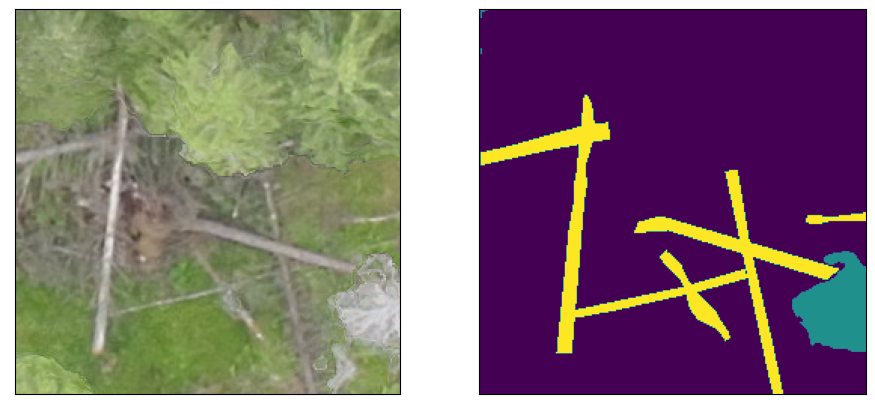

In [7]:
ex_file = random.sample(os.listdir(outpath/d/'rasterized_vector_tiles'), 1)[0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])
with rio.open(outpath/d/"raster_tiles"/ex_file) as im:
    rioplot.show(im, ax=axs[0])
with rio.open(outpath/d/"rasterized_vector_tiles"/ex_file) as mask:
    rioplot.show(mask, ax=axs[1])
    #rioplot.show((mask, 1), ax=axs[1]) # Changed to (mask, 1) due to an error in image handling. (mask, 1) shows the 1st band which has all the classes, groundwood, upright wood and background. Changed from: rioplot.show(mask, ax=axs[1])

## 3 Setting up the data loaders for segmentation <a class="anchor" id="chapter3"></a>

The data loaders are used to tell fastai where the data is located, how it's labeled, the validation-train split, and what transformations (augmentations) to make on the data.

We use 20 % of the data for validation. By setting `seed=96` we always use the same virtual plots for model validation.

In [3]:
outpath = Path('/scratch/deadwood/segmentation/models/proto10new/processed/')

if not os.path.exists(outpath): os.makedirs(outpath)

fnames = [Path(f'{outpath}/{tile}/raster_tiles/{f}') 
         for tile in [til for til in os.listdir(outpath) if os.path.isdir(outpath/til) and til not in ['segmentation', 'models']]
         for f in os.listdir(outpath/tile/'rasterized_vector_tiles')]

dls = SegmentationDataLoaders.from_label_func('/scratch/deadwood/segmentation/models/proto10new/processed',
                                              valid_pct=0.2, seed=96, bs=16, # 11.5.2022: Added "valid_pct=0.2" and "seed=96" so that the validation set always contains the same virtual plots.
                                              codes=['Standing', 'Fallen'],
                                              fnames = fnames,
                                              label_func=partial(label_from_different_folder,
                                                                 original_folder='raster_tiles',
                                                                 new_folder='rasterized_vector_tiles'),
                                              item_tfms=[Resize(256)],
                                                   batch_tfms= [
                                                       *aug_transforms(size=224,
                                                                       do_flip=True,
                                                                       max_rotate=10,
                                                                       max_lighting=0.2,
                                                                       p_lighting=0.5,
                                                                       pad_mode='zeros'), # Added transform on 25.11.2022
                                                       Normalize.from_stats(*imagenet_stats)
                                              ],
                                              num_workers=0)

`label_from_different_folder` is a helper located in `drone_detector.engines.fastai.data`. That module also contains helpers to use with for instance multispectral images or time series of images.

Running `dls.show_batch` shows the original image in the left-hand column and the manually delineated an annotated target on the right-hand one.

In [ ]:
#doc(dls.show_batch)

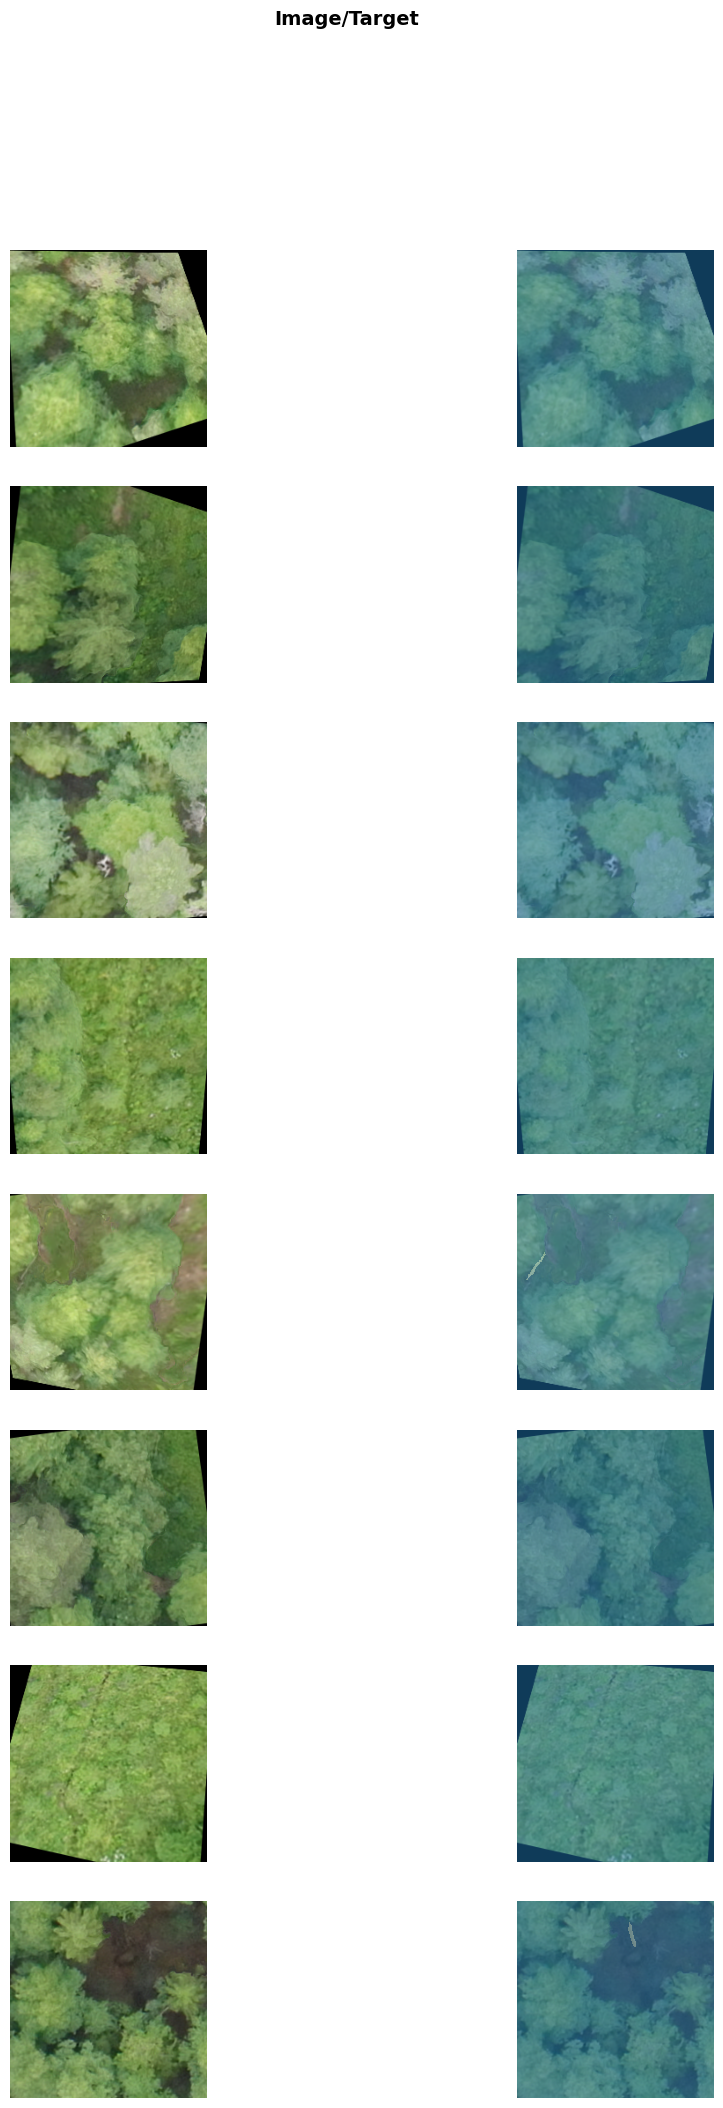

In [3]:
dls.show_batch(max_n=16)

## 4 Training the model <a class="anchor" id="chapter4"></a>

**From Janne's notebook:**
*Train basic U-Net, using pretrained Resnet50 as the encoder. `to_fp16()` tells our model to use half precision training, thus using less memory. Loss function is `FocalLossFlat`, and for segmentation we need to specify `axis=1`. Metrics are `Dice` and `JaccardCoeff`, fairly standard segmentation metrics.*

We change the metrics to `DiceMulti()`, `JaccardCoeffMulti()`. `JaccardCoeffMulti` is in `drone_detector.metrics`.

`n_out` should be 3, (`n_out=3`) because we have 3 classes (groundwood, standing and the background).

In [ ]:
#doc(unet_learner)
#doc(JaccardCoeffMulti())
#doc(JaccardCoeff())

**10.12.2022:**  
Testing that the code works with different loss functions:
1. [x] Cross Entropy
2. [x] Label Smoothing Cross Entropy Flat
3. [x] Focal Loss Flat

**17.11.2022:**  
Testing using `accuracy_multi()`, `%precision`, and `%recall` as metrics. 
Syntax error when using `%precision`, and `%recall`. Larger error when using `accuracy_multi()`. Are these metrics even useful for me? Maybe not.

In [11]:
learn = unet_learner(dls, resnet50, pretrained=True, n_in=3, n_out=3,
                     metrics=[DiceMulti(), JaccardCoeffMulti()], 
                     loss_func=FocalLossFlat(axis=1)
                     ).to_fp16()

Search for a suitable learning rate.

SuggestedLRs(valley=7.585775892948732e-05)

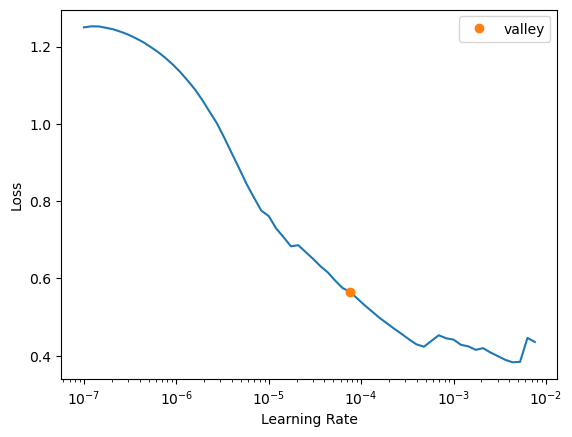

In [13]:
learn.lr_find()

The training is tracked using wandb.

In [2]:
wandb.init(name = 'LFFocalLossFlat01',
           project = 'proto10new')

wandb: Currently logged in as: tvtv. Use `wandb login --relogin` to force relogin


Train the model for 2 epochs with encoder layers frozen and 10 epochs with all layers unfrozen.

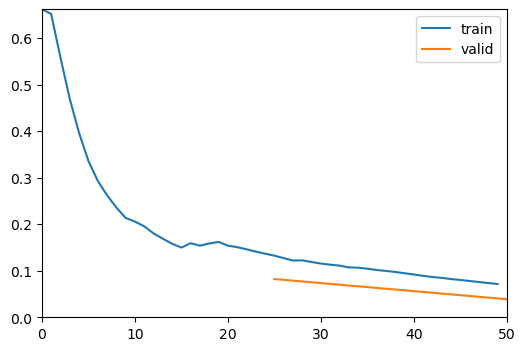

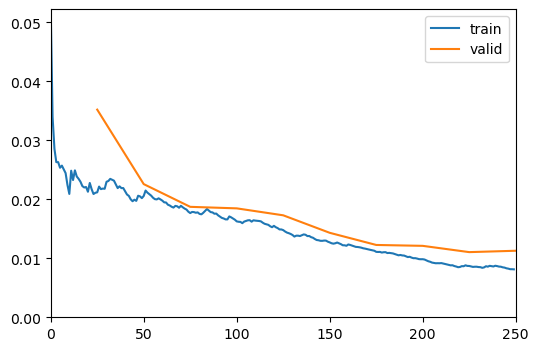

In [6]:
learn.fine_tune(10, freeze_epochs=2, base_lr=1e-4, cbs=[ShowGraphCallback, WandbCallback(log_preds_every_epoch=True)])

Return to full precision.

In [56]:
learn.to_fp32()

In [17]:
#wandb.finish()

Check results.

RuntimeError: number of dims don't match in permute

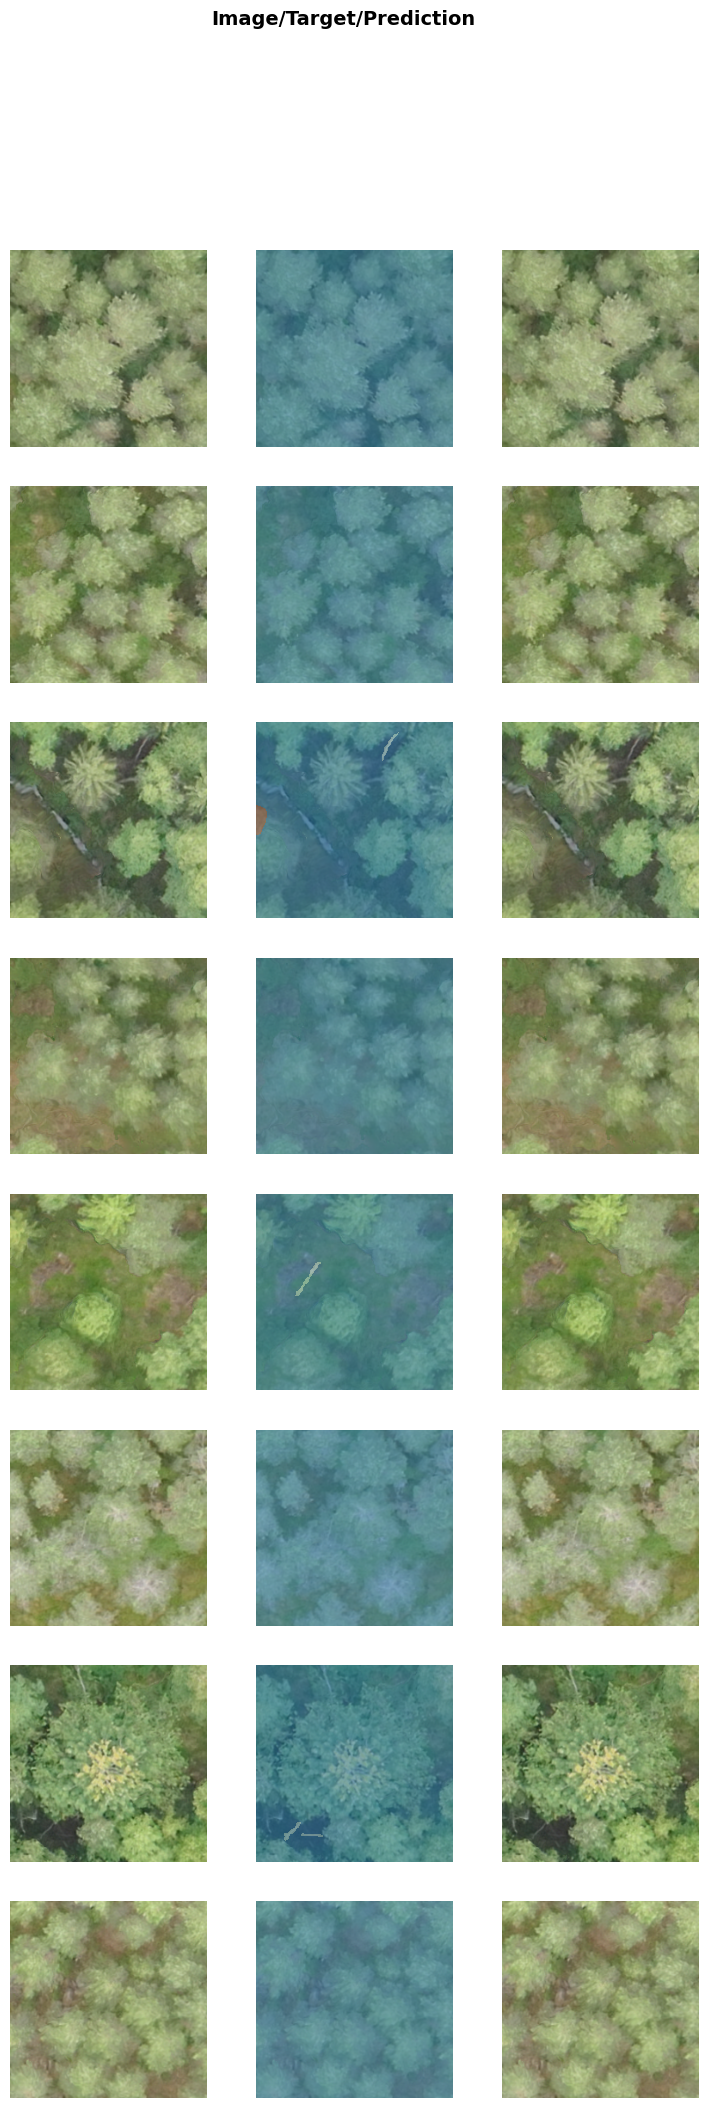

In [57]:
learn.show_results(max_n=8)

Export the model for later use.

In [58]:
learn.path = Path('/scratch/deadwood/segmentation/models/proto10new/models')
#learn.export('unet-segmentation-test-proto10new-00.pkl')
learn.export('unet-segmentation-test-proto10new-LF_LSCE-00.pkl') # Loss function = Binary Cross Entropy

## 5 Test with holdout <a class="anchor" id="chapter5"></a>

Here the models are evaluated by showing them data that they haven't seen, i.e. a test set.  

This part is from `U-Net Hiidenportti.ipynb`. ~~Model testing can be run from the Jupyter notebook, no need to run a batch job.~~

**31.5.2022:** `predict_segmentation_fastai` doesn't create any files anymore.

**25.5.2022:** It works! There had been an issue with the Tiler, where some tiles were of size 257x256, which caused a crash.

**20.5.2022:** Running the third cell resulted in it only printing `Folder exists`. This was due to that the `processing_dir='temp'` already existed. Deleting the`temp` folder or using a different folder resolves this issue.

**17.5.2022:** Does not seem to work?  

In [7]:
from drone_detector.engines.fastai.predict import predict_segmentation_fastai
# from drone_detector.engines.fastai.predict import predict_segmentation is used in U-Net Hiidenportti.ipynb.

Define which images to use for testing the model:

In [8]:
test_rasters = [f'/scratch/deadwood/segmentation/models/proto10new/test/images/{f}'

                for f in os.listdir('/scratch/deadwood/segmentation/models/proto10new/test/images/') if f.endswith('tif')]

### 5.1 Predictions <a class="anchor" id="section_5_1"></a>

Use the model we trained earlier. We run the model on images from the test set, which are images that the model has not seen before.

**11.12.2022:**  
Testing predictions using different tile overlap:  
1. [x] Overlap 0
2. [x] Overlap 64
2. [x] Overlap 128

**10.12.2022:**  
Testing predictions using models with different loss functions:
1. [x] Cross Entropy
2. [x] Label Smoothing Cross Entropy Flat
3. [x] Focal Loss Flat

In [9]:
for t in test_rasters:
    outfile_name = f'/scratch/deadwood/segmentation/models/proto10new/test/predictions/{t.split("/")[-1]}'
    # 31.5.2022: Moved the result files to /scratch/deadwood/segmentation/models/proto10new/test/predictions and changed the output folder to be the same. Old output folder = /scratch/deadwood/segmentation/models/proto10new/test/results/
    
    predict_segmentation_fastai('/scratch/deadwood/segmentation/models/proto10new/models/unet-segmentation-test-proto10new-LF_FLF-00.pkl', t, outfile_name, # 17.5.2022: Changed from "predict_segmentation" to "predict_segmentation_fastai"
                         processing_dir='test-temp0', use_tta=False,
                         tile_size=256, tile_overlap=128) # tile_size=230 and tile_overlap=115 in the original code

Reading and tiling /scratch/deadwood/segmentation/models/proto10new/test/images/16_1140.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.9/site-packages/fastai/metrics.py:372: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/deadwood/drone_detector/drone_detector/metrics.py:98: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling /scratch/deadwood/segmentation/models/proto10new/test/images/34_1200.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.9/site-packages/fastai/metrics.py:372: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/deadwood/drone_detector/drone_detector/metrics.py:98: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files


In [15]:
outfile_name

'/scratch/deadwood/segmentation/models/proto10new/test/predictions/34_1200.tif'

In [ ]:
#doc(predict_segmentation_fastai)

In [7]:
from osgeo import gdal, ogr

**16.11.2022**  
There was a lot of confusion regarding from where the joined (big) rasterized vector tiff-images came from.
The part with `rasterized_vector_path` in the cell below had this comment: 

>The rasterized predictions created in the "Test with holdout" part by predict_segmentation_fastai.

These are NOT created by predict_segmentation_fastai, but rather by `tqdm import tqdm`. 


**Some notes I made while figuring out the origin of the joined rasterized vector tiff images**:  

"Moved the `outfile_name` outfiles to `/scratch/deadwood/segmentation/models/proto10new/test/results/`"

- When did I make this comment?
    - Unknown as of 16.11.2022
- Why did I move the files?
- Are the files there as of 16.11.2022?
    - Yes
- Are the `/scratch/deadwood/segmentation/models/proto10new/test/results/`files used anywhere later in the code?
    - Yes. They are used in the U-net Hiidenportti metrics calculation chapter as  
     `rasterized_vector_path = '/scratch/deadwood/segmentation/models/proto10new/test/results'`
     - **The `test/results` files are the rasterized digitized deadwood vectors**
         - But when are these files made? They just exist.
             - Looks like they are created by `from tqdm import tqdm`? Check.
                 - Seems like the confusion stems from the cells being in the wrong order. The `from tqdm import tqdm` part comes first in the U-Net Hiidenportti notebook.
                 - [x] 16.11.2022: Rearranged the cell order to match the one in U-Net Hiidenportti.
                 - [x] 16.11.2022: Create a different folder for the joined rasterized vector tile image. New folder: `/scratch/deadwood/segmentation/models/proto10new/test/truths`
- What if I use the `/scratch/deadwood/segmentation/models/proto10new/test/predictions/`files instead?


In [16]:
raster_path = '/scratch/deadwood/segmentation/models/proto10new/test/images/' # The virtual plots
#vector_path = '/scratch/deadwood/segmentation/models/proto10new/test/results' # Digitized deadwood
#rasterized_vector_path = '/scratch/deadwood/segmentation/models/proto10new/test/vectors' # The rasterized predictions created in the "Test with holdout" part by predict_segmentation_fastai.
vector_path = '/scratch/deadwood/segmentation/models/proto10new/test/vectors' # Digitized deadwood
rasterized_vector_path = '/scratch/deadwood/segmentation/models/proto10new/test/truths' 

if not os.path.exists(rasterized_vector_path): os.makedirs(rasterized_vector_path)

raster_files = sorted([f for f in os.listdir(raster_path)])
vector_files = sorted([f for f in os.listdir(vector_path)])

In [17]:
from tqdm import tqdm
column = 'groundwood'
for r, v in tqdm(zip(raster_files, vector_files)):
    source_raster = gdal.Open(f'{raster_path}/{r}', gdal.GA_ReadOnly)
    source_vector = ogr.Open(f'{vector_path}/{v}')
    source_vector_layer = source_vector.GetLayer()

    output_raster = gdal.GetDriverByName('gtiff').Create(f'{rasterized_vector_path}/{r}',
                                                         source_raster.RasterXSize,
                                                         source_raster.RasterYSize,
                                                         1,
                                                         gdal.GDT_Int16)
    output_raster.SetProjection(source_raster.GetProjectionRef())
    output_raster.SetGeoTransform(source_raster.GetGeoTransform())
    band = output_raster.GetRasterBand(1)
    #band.SetNoDataValue(0)
    gdal.RasterizeLayer(output_raster, [1], source_vector_layer, options=[f'ATTRIBUTE={column}'])

    band = None
    source_vector = None
    source_raster = None
    output_raster = None   

2it [00:00,  6.14it/s]


In [18]:
import rasterio as rio
import rasterio.mask as rio_mask
from shapely.geometry import box

result_path = '/scratch/deadwood/segmentation/models/proto10new/test/predictions' 

for f, pred, truth in zip(sorted(os.listdir(vector_path)), sorted(os.listdir(result_path)), sorted(os.listdir(rasterized_vector_path))):
    temp_gdf = gpd.read_file(f'{vector_path}/{f}')
    
    shapes = [box(*temp_gdf.total_bounds)]
    
    with rio.open(f'{result_path}/{pred}') as src:
        out_im, out_tfm = rio_mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_im.shape[1],
                     "width": out_im.shape[2],
                     "transform": out_tfm})
    
    
    with rio.open(f'{result_path}/{pred}', "w", **out_meta) as dest:
        dest.write(out_im)
        
    with rio.open(f'{rasterized_vector_path}/{truth}') as src:
        out_im, out_tfm = rio_mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_im.shape[1],
                     "width": out_im.shape[2],
                     "transform": out_tfm})
    
    
    with rio.open(f'{rasterized_vector_path}/{truth}', "w", **out_meta) as dest:
        dest.write(out_im)

In [19]:
import matplotlib.pyplot as plt
import rasterio.plot as rioplot

<AxesSubplot: >

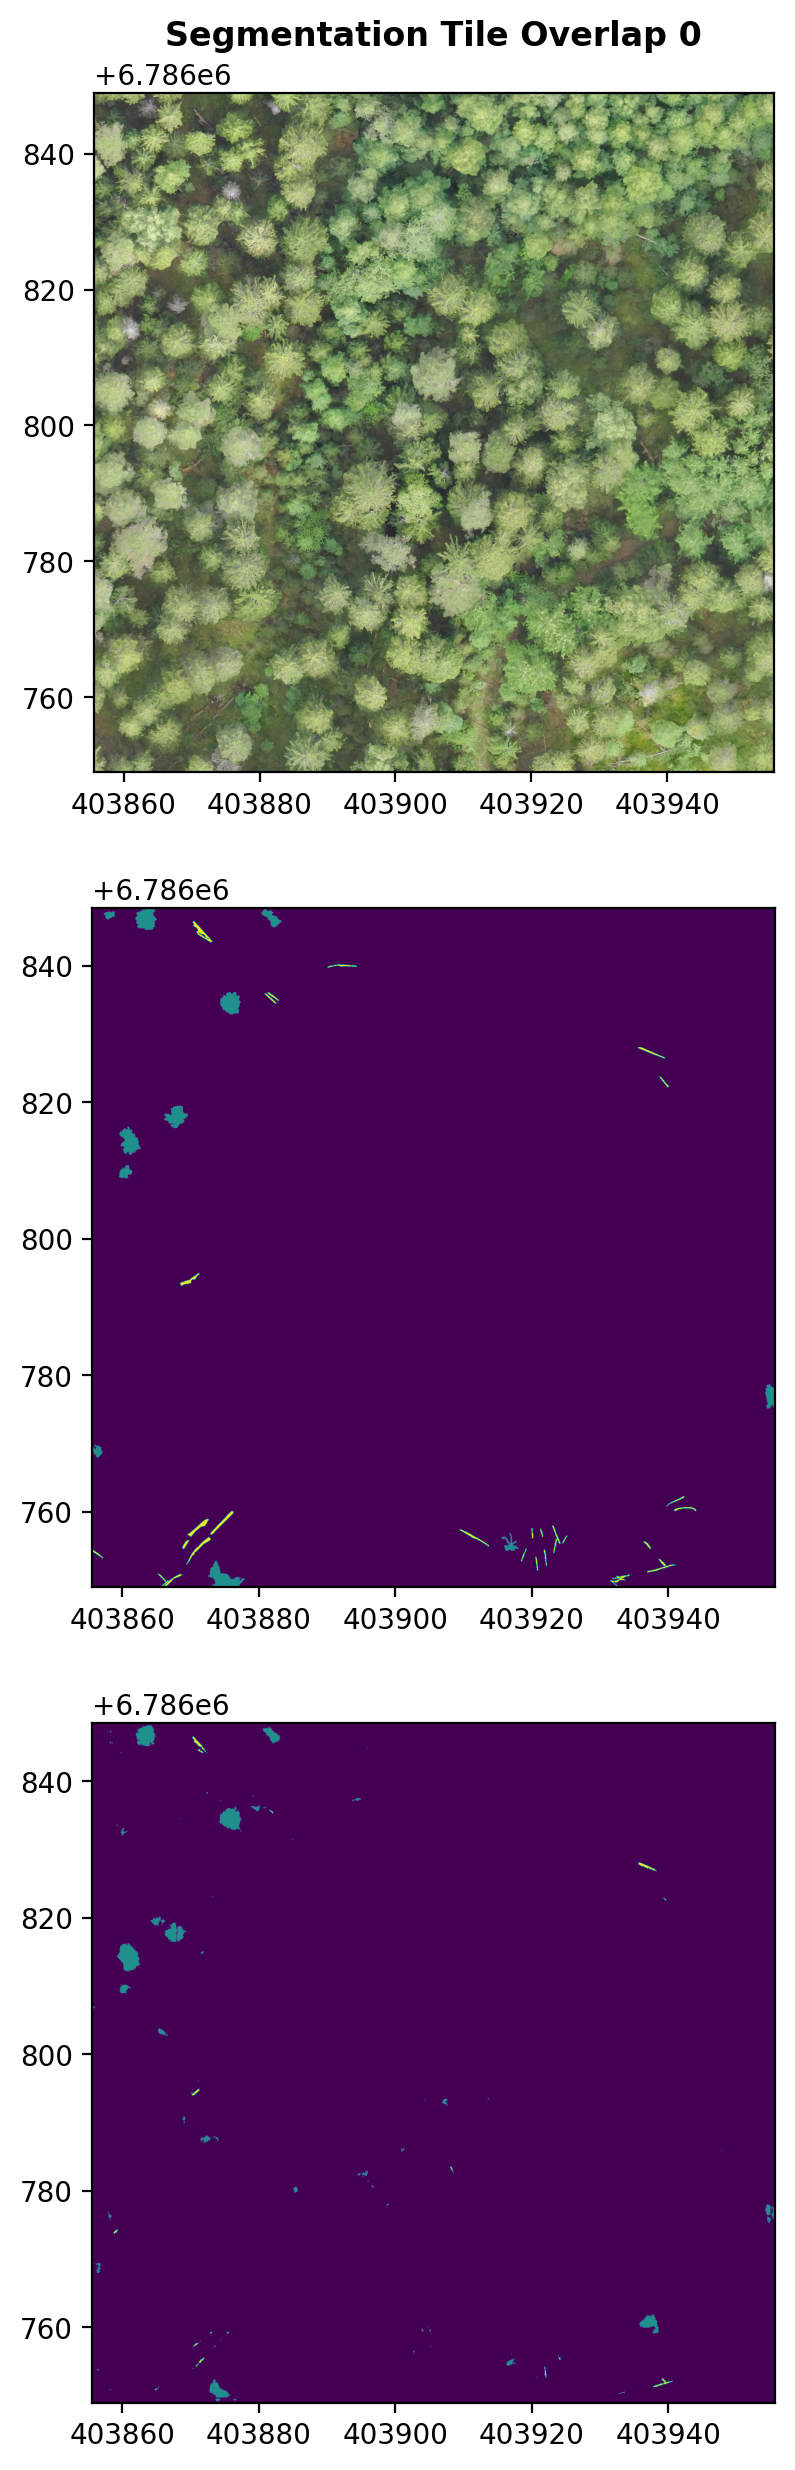

In [24]:
fig, axs = plt.subplots(3,1, figsize=(7,15), dpi=200)

ix = 1
#ix = random.randint(0,1)
truths = sorted(os.listdir(rasterized_vector_path))
preds = sorted(os.listdir(result_path))

im = rio.open(f'{raster_path}/{truths[ix]}')
rioplot.show(im, ax=axs[0], title = 'Segmentation Tile Overlap 0')

truth = rio.open(f'{rasterized_vector_path}/{truths[ix]}')
rioplot.show(truth, ax=axs[1], vmin=0, vmax=2)

pred = rio.open(f'{result_path}/{truths[ix]}')
rioplot.show(pred, ax=axs[2], vmin=0, vmax=2)

In [22]:
ix

0

## 6 Calculating metrics <a class="anchor" id="chapter6"></a>

The metrics for model performance are calculated.  

**22.11.2022:**  
The belowmentioned issue should be cleared by using the `from shapely.geometry` code block. It puts the data into a bounding box and aligns them based on the coordinates.

**17.11.2022:**  
An issue I came across is how to calculate the metrics for ALL the test images, not just for one like the code does below.

In [37]:
def binary_mask_iou(pred, truth, label=1):
    p = np.where(pred == label, 1, 0).ravel()
    t = np.where(truth == label, 1, 0).ravel()
    inter = (p*t).sum()
    union = (p+t).sum()
    #inter = (p.dot(t)).sum()
    #union = (p+t).sum()
    #if t.sum() == 0: return 'No ground truth'
    #elif p.sum() == 0: return 'No predicted class'
    return inter/(union-inter) if union > 0 else None

In [38]:
from shapely.geometry import box

bg_preds = np.array([])
bg_truths = np.array([])
standing_preds = np.array([])
standing_truths = np.array([])
fallen_preds = np.array([])
fallen_truths = np.array([])


for t, p in list(zip(truths, preds)):
    with rio.open(f'{rasterized_vector_path}/{t}') as truth_src:
        bounds_truth = truth_src.bounds
        with rio.open(f'{result_path}/{p}') as pred_src:
            bounds_pred = pred_src.bounds
            pred,_ = rio.mask.mask(pred_src, [box(*bounds_pred).intersection(box(*bounds_truth))], crop=True)
            pred = pred[0]
        truth, _ = rio.mask.mask(truth_src, [box(*bounds_pred).intersection(box(*bounds_truth))], crop=True)
        truth = truth[0]
    bg_preds = np.append(bg_preds, np.where(pred==0, 1, 0).ravel())
    bg_truths = np.append(bg_truths, np.where(truth==0, 1, 0).ravel())
    standing_preds = np.append(standing_preds, np.where(pred==1, 1, 0).ravel())
    standing_truths = np.append(standing_truths, np.where(truth==1, 1, 0).ravel())
    fallen_preds = np.append(fallen_preds, np.where(pred==2, 1, 0).ravel())
    fallen_truths = np.append(fallen_truths, np.where(truth==2, 1, 0).ravel())
    
bg_inter = (bg_preds*bg_truths).sum()
bg_union = (bg_preds+bg_truths).sum()
standing_inter = (standing_preds*standing_truths).sum()
standing_union = (standing_preds+standing_truths).sum()
fallen_inter = (fallen_preds*fallen_truths).sum()
fallen_union = (fallen_preds+fallen_truths).sum()

In [39]:
bg_iou = bg_inter / (bg_union - bg_inter)
standing_iou = standing_inter / (standing_union - standing_inter)
fallen_iou = fallen_inter / (fallen_union - fallen_inter)

bg_dice = 2 * bg_inter / bg_union
fallen_dice = 2 * fallen_inter / fallen_union
standing_dice = 2 * standing_inter / standing_union

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
standing_accuracy = accuracy_score(fallen_truths, fallen_preds)
fallen_accuracy = accuracy_score(fallen_truths, fallen_preds)
standing_pre = precision_score(standing_truths, standing_preds)
standing_rec = recall_score(standing_truths, standing_preds)
fallen_pre = precision_score(fallen_truths, fallen_preds)
fallen_rec = recall_score(fallen_truths, fallen_preds)
overall_pre = (standing_pre + fallen_pre) / 2
overall_rec = (standing_rec + fallen_rec) / 2

In [41]:
bg_iou

0.968021244405112

In [42]:
standing_iou

0.3213720650591735

In [43]:
fallen_iou

0.14159988365024967

In [44]:
bg_dice

0.9837508077284224

In [45]:
fallen_dice

0.24807270161501072

In [46]:
standing_dice

0.48642176349442023

In [47]:
standing_accuracy

0.9720915322474557

In [48]:
fallen_accuracy

0.9720915322474557

In [49]:
standing_pre

0.35744620943710553

In [50]:
standing_rec

0.76101508642222

In [51]:
fallen_pre

0.2128872741951761

In [52]:
fallen_rec

0.29719174115179314

In [53]:
overall_pre

0.2851667418161408

In [54]:
overall_rec

0.5291034137870065

In [55]:
# This is just some testing
from sklearn.metrics import classification_report
y_true = fallen_truths
y_pred = fallen_preds
target_names = ['Standing', 'Fallen']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Standing       0.99      0.98      0.99   8120125
      Fallen       0.21      0.30      0.25    127766

    accuracy                           0.97   8247891
   macro avg       0.60      0.64      0.62   8247891
weighted avg       0.98      0.97      0.97   8247891



In [32]:
learn.validate() # Prints the loss, dicemulti and jaccard multi

(#3) [0.5664160251617432,0.0072347578223246264,0.0037160262825871896]

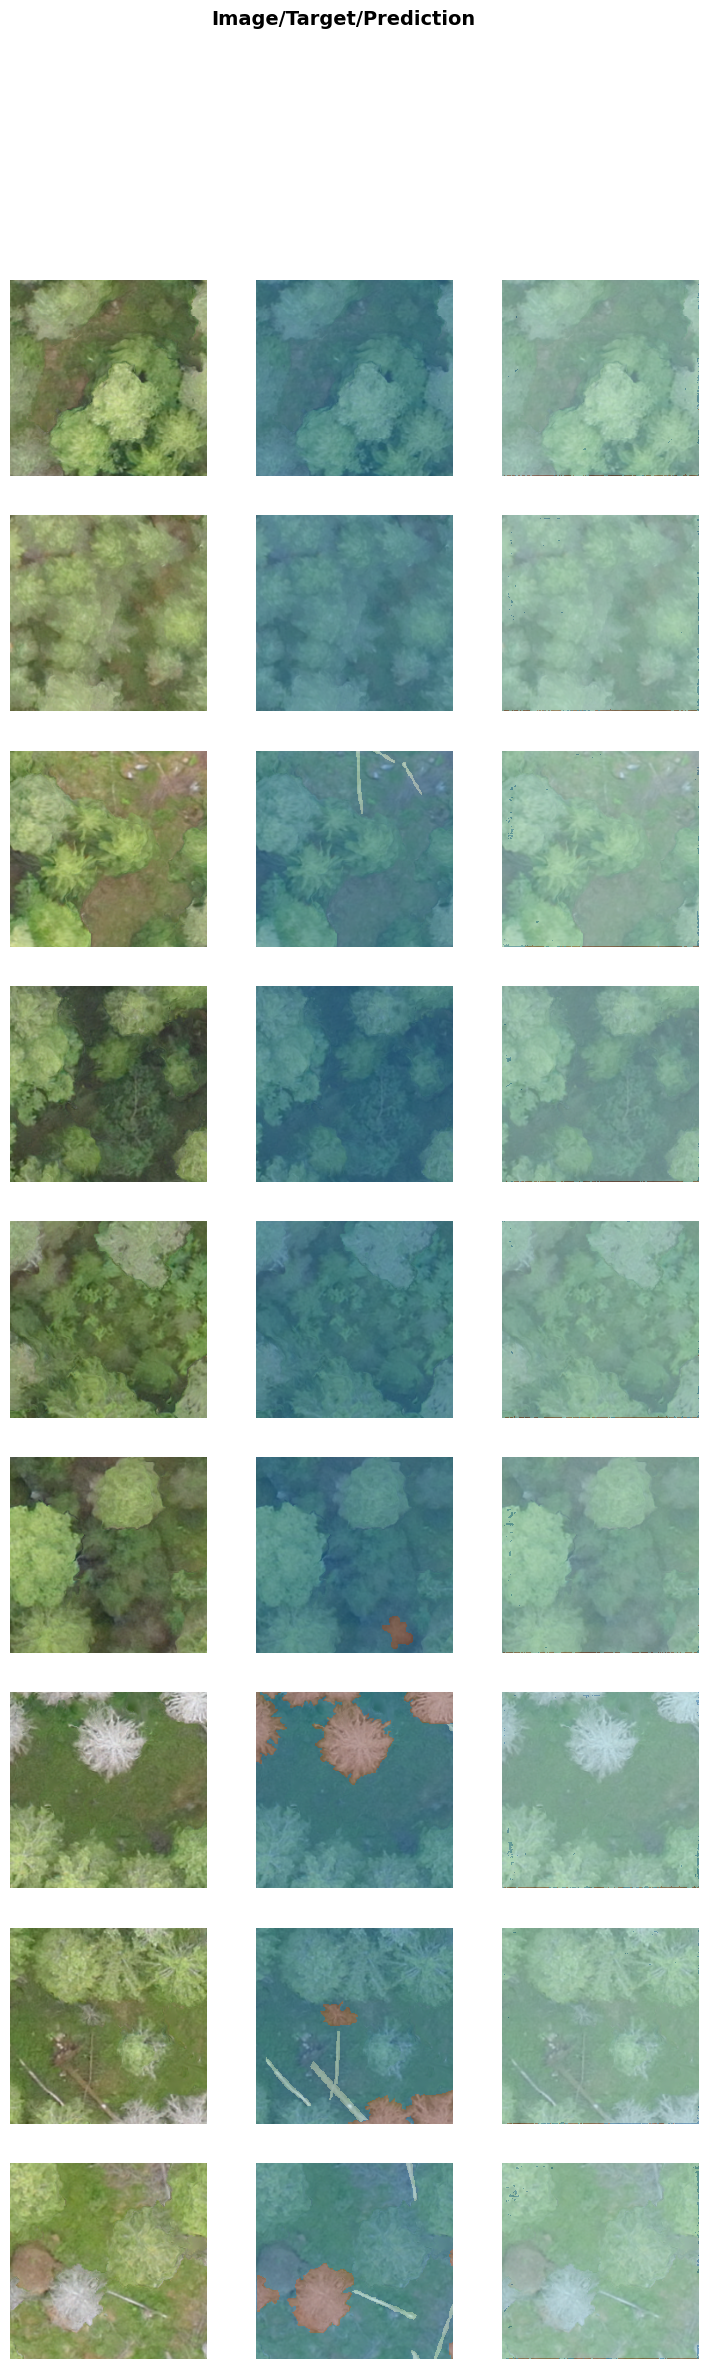

In [31]:
learn.show_results()

In [56]:
wandb.finish()

***
### Simpler method for metrics calculation

This method does not work if the targets and predictions are of different dimensions, e.g. 2062 * 2063 pixels and 2051 * 2052 pixels. 

**24.11.2022:**  
I'm going to use the method above for metrics calculationg, but leaving this method here for reference.

#### Calculating Precision & Recall
Added on 16.11.2022.

#### Calculating Accuracy
From the U-Net Hiidenportti. This part is not working as of 16.11.2022.

In [ ]:
def accuracy_annotated(pred, truth, label):
    pred = pred.copy()
    pred[truth == 0] = 0
    p = np.where(pred == label, 1, 0).ravel()
    t = np.where(truth == label, 1, 0).ravel()
    return p.sum() / t.sum()

In [ ]:
accuracy_annotated(pred_vals, truth_vals, 2)

In [ ]:
standing_masked_preds = np.array([])
standing_truths = np.array([])
fallen_masked_preds = np.array([])
fallen_truths = np.array([])


for t, p in list(zip(truths, preds)):
    truth = rio.open(f'{rasterized_vector_path}/{t}').read()
    pred = rio.open(f'{result_path}/{p}').read()
    pred[truth == 0] = 0
    standing_masked_preds = np.append(standing_masked_preds, np.where(pred==1, 1, 0).ravel())
    standing_truths = np.append(standing_truths, np.where(truth==1, 1, 0).ravel())
    fallen_masked_preds = np.append(fallen_masked_preds, np.where(pred==2, 1, 0).ravel())
    fallen_truths = np.append(fallen_truths, np.where(truth==2, 1, 0).ravel())
    
standing_ann_acc = standing_masked_preds.sum() / standing_truths.sum()
fallen_ann_acc = fallen_masked_preds.sum() / fallen_truths.sum()

In [ ]:
standing_ann_acc

In [ ]:
fallen_ann_acc

### These are part of some testing I did

In [ ]:
with rio.open('/scratch/deadwood/segmentation/models/proto10new/test/images/16_1140.tif') as im:
    rioplot.show(im)#, ax=axs[0])

In [ ]:
# 16.11.2022: Changed the path from 
# /scratch/deadwood/segmentation/models/proto10new/test/results/16_1140.tif
# to /scratch/deadwood/segmentation/models/proto10new/test/truths/16_1140.tif

with rio.open('/scratch/deadwood/segmentation/models/proto10new/test/truths/16_1140.tif') as im:
    rioplot.show(im)#, ax=axs[0])
    print(im.shape)

#with rio.open(outpath/d/"raster_tiles"/ex_file) as im:
 #   rioplot.show(im, ax=axs[0])

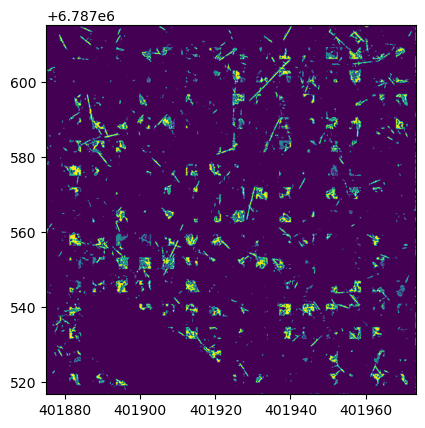

(2031, 2030)


In [84]:
with rio.open('/scratch/deadwood/segmentation/models/proto10new/test/predictions/16_1140.tif') as im:
    rioplot.show(im)#, ax=axs[0])
    print(im.shape)

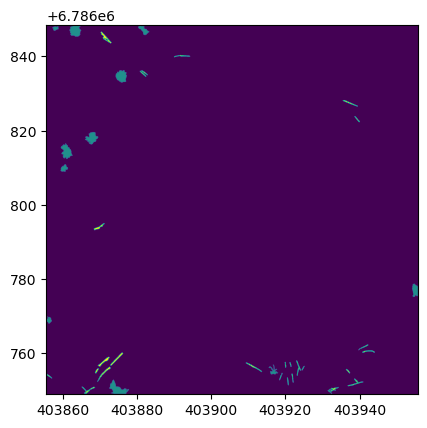

(2052, 2063)


In [58]:
with rio.open('/scratch/deadwood/segmentation/models/proto10new/test/truths/34_1200.tif') as im:
    rioplot.show(im)#, ax=axs[0])
    print(im.shape)

#with rio.open(outpath/d/"raster_tiles"/ex_file) as im:
 #   rioplot.show(im, ax=axs[0])

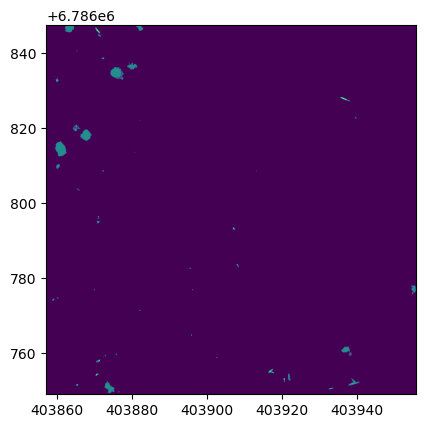

(2031, 2031)


In [59]:
with rio.open('/scratch/deadwood/segmentation/models/proto10new/test/predictions/34_1200.tif') as im:
    rioplot.show(im)#, ax=axs[0])
    print(im.shape)

In [ ]:
#for fname in os.listdir(vector_path):
#    gdf = gpd.read_file(vector_path/fname)
#    gdf['groundwood'] = gdf.apply(lambda row: 2 if row.label == 'groundwood' else 1, axis=1)
#    gdf.to_file(vector_path/fname)

## From [Using fastai for segmentation](https://jaeeolma.github.io/drone_detector/examples.fastai.segmentation.html)

Some helper functions for inference, such as removing all resizing transforms.

In [ ]:
def label_func(fn):
    return str(fn).replace('raster_tiles', 'mask_tiles')

@patch 
def remove(self:Pipeline, t):
    for i,o in enumerate(self.fs):
        if isinstance(o, t.__class__): self.fs.pop(i)
            
@patch
def set_base_transforms(self:DataLoader):
    attrs = ['after_item', 'after_batch']
    for i, attr in enumerate(attrs):
        tfms = getattr(self, attr)
        for j, o in enumerate(tfms):
            if hasattr(o, 'size'):
                tfms.remove(o)
            setattr(self, attr, tfms)

Load learners and remove all resizing transforms. If you run out of memory just restart the kernel.

In [ ]:
doc(load_learner)

In [16]:
testlearn = load_learner('/scratch/deadwood/segmentation/models/proto10new/models/unet-segmentation-test-proto10new-LF_FLF-00.pkl', cpu=False)
testlearn.dls.valid.set_base_transforms()

In [33]:
doc(testlearn.predict)

In [26]:
import PIL
def unet_predict(fn):
    image = np.array(PIL.Image.open(fn))
    mask = testlearn.predict(PILImage.create(image))[0].numpy()
    img = image
    img[:,:,0][mask==0] = 0
    img[:,:,1][mask==0] = 0
    img[:,:,2][mask==0] = 0
    img = PIL.Image.fromarray(img.astype(np.uint8))
    return img

In [27]:

test_images = [f'/scratch/deadwood/segmentation/models/proto10new/test/images/{f}' for f in os.listdir('/scratch/deadwood/segmentation/models/proto10new/test/images/')]

### First result

#### Calculating metrics

Here we calculate the model metrics: `accuracy`, `precision`, `recall`, `Dice (F1)`, and `IoU (Jaccard Index`.

In [40]:
doc(learn.show_results)

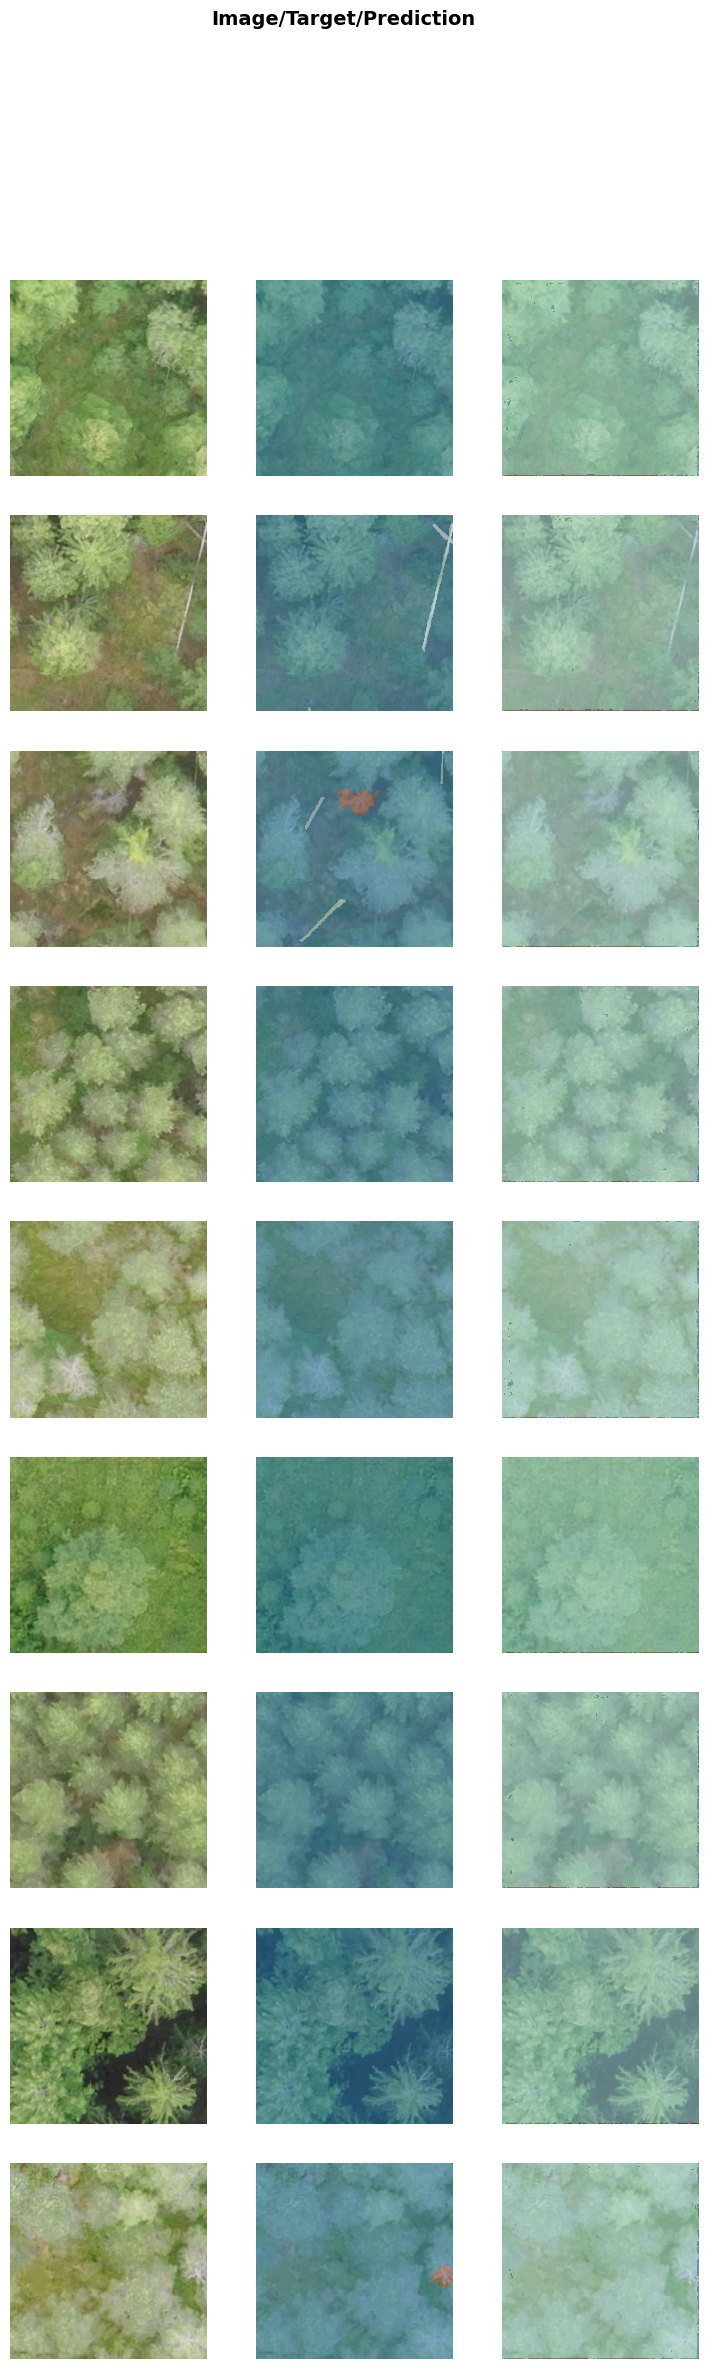

In [21]:
learn.show_results(ds_idx=1)

In [ ]:
patch_pred = unet_predict(test_images[0])

fig, axs = plt.subplots(1,2, figsize=(10,5),dpi=300)
for a in axs:
    a.set_yticks([])
    a.set_xticks([])
axs[0].imshow(PIL.Image.open(test_images[0]))
axs[1].imshow(patch_pred)
axs[0].set_title(test_images[0].split('/')[-1])
axs[1].set_title('Predicted downed deadwood')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5),dpi=300)
for a in axs:
    a.set_yticks([])
    a.set_xticks([])
axs[0].imshow(PIL.Image.open(test_images[0]))
axs[1].imshow(patch_pred)
axs[0].set_title(test_images[0].split('/')[-1])
axs[1].set_title('Predicted deadwood')
plt.show()

### Second result

In [ ]:
patch_pred = unet_predict(test_images[1])

fig, axs = plt.subplots(1,2, figsize=(10,5),dpi=300)
for a in axs:
    a.set_yticks([])
    a.set_xticks([])
axs[0].imshow(PIL.Image.open(test_images[1]))
axs[1].imshow(patch_pred)
axs[0].set_title(test_images[1].split('/')[-1])
axs[1].set_title('Predicted deadwood')
plt.show()

## Calculating metrics

***
### From the original notebook:

In [ ]:
patch_pred = unet_predict(test_images[1])

fig, axs = plt.subplots(1,2, figsize=(10,5),dpi=300)
for a in axs:
    a.set_yticks([])
    a.set_xticks([])
axs[0].imshow(PIL.Image.open(test_images[1]))
axs[1].imshow(patch_pred)
axs[0].set_title(test_images[1].split('/')[-1])
axs[1].set_title('Predicted marshes')
plt.show()

Third result

In [ ]:
patch_pred = unet_predict(test_images[2])

fig, axs = plt.subplots(1,2, figsize=(10,5),dpi=300)
for a in axs:
    a.set_yticks([])
    a.set_xticks([])
axs[0].imshow(PIL.Image.open(test_images[2]))
axs[1].imshow(patch_pred)
axs[0].set_title(test_images[2].split('/')[-1])
axs[1].set_title('Predicted marshes')
plt.show()

Fourth example.

In [ ]:
patch_pred = unet_predict(test_images[3])

fig, axs = plt.subplots(1,2, figsize=(10,5),dpi=300)
for a in axs:
    a.set_yticks([])
    a.set_xticks([])
axs[0].imshow(PIL.Image.open(test_images[3]))
axs[1].imshow(patch_pred)
axs[0].set_title(test_images[3].split('/')[-1])
axs[1].set_title('Predicted marshes')
plt.show()

In [ ]:
# hide

from nbdev.export import notebook2script
notebook2script()
!nbdev_build_docs